In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

In [216]:
args = {'lr':0.001,
        'batch_size':32,
        'epochs':1000,
        'noise':0.0001,
        'direction':0,
        'train_size':0.7
        }

# Prepare Data

In [217]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=args['direction'], noise_scale=args['noise'])

In [218]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [219]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [220]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 60)
        self.lin2 = nn.Linear(60, 60)
        self.lin3 = nn.Linear(60, 30)
        self.lin4 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin2(output))
        output = self.lin_fin(output)
        return output

In [221]:
n_samples = len(train_dataset)
_, input_size = dataset.x.shape
_, output_size = dataset.y.shape

model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [222]:
learning_rate = args['lr']
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [223]:
num_epochs = args['epochs']
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # forward pass and loss
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

print(f'\nbest loss: {best_loss:.2f} in epoch: {best_epoch}')

epoch: 100, loss = 256.9812
epoch: 200, loss = 167.2969
epoch: 300, loss = 132.5945
epoch: 400, loss = 202.0744
epoch: 500, loss = 74.8476
epoch: 600, loss = 113.7371
epoch: 700, loss = 107.6076
epoch: 800, loss = 56.4413
epoch: 900, loss = 82.4951
epoch: 1000, loss = 52.7474

best loss: 20.02 in epoch: 773


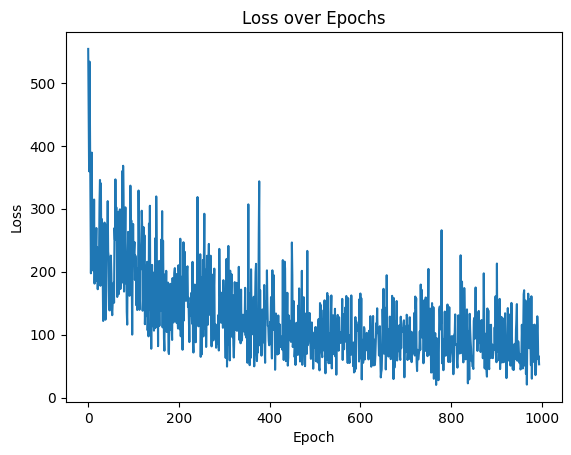

In [224]:
plt.plot(loss_list[5:])

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [225]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    if args['direction']:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

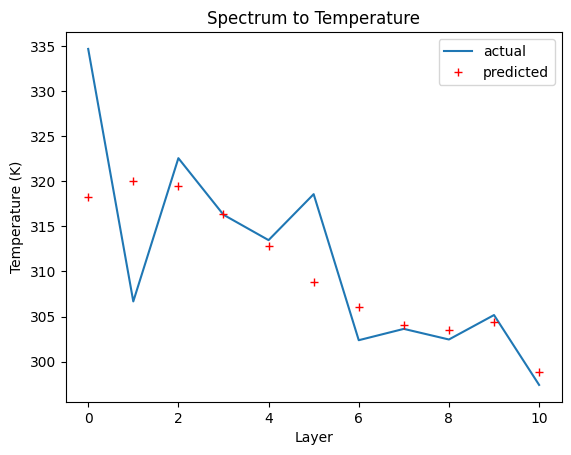

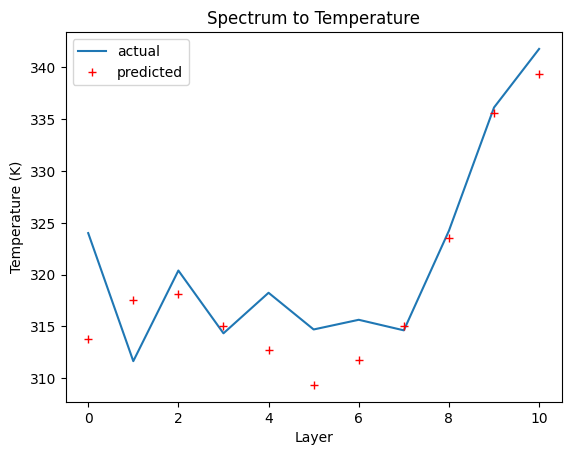

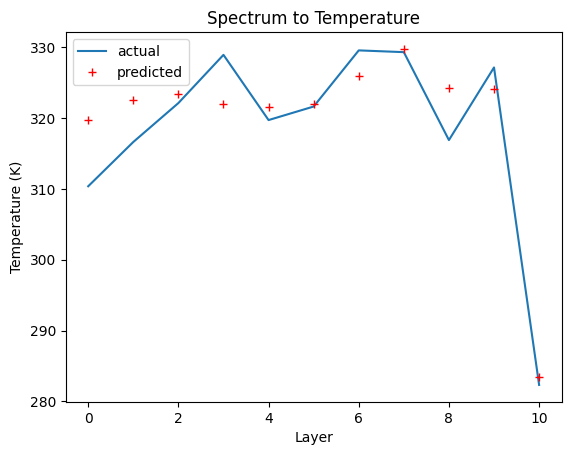

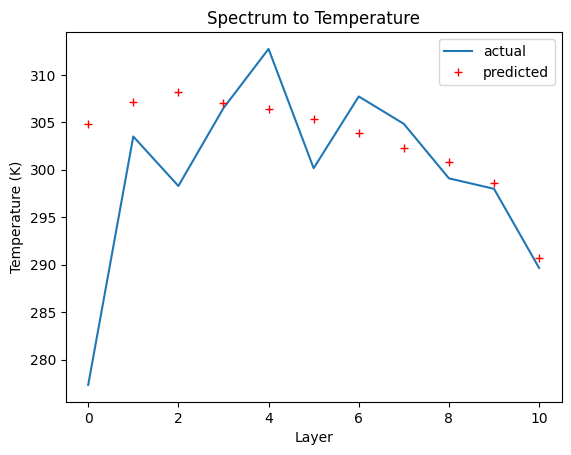

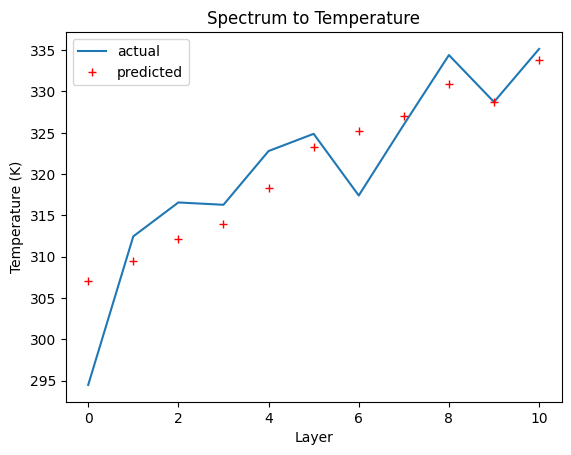

average loss: 82.23878224690755


In [226]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        inputs = X_batch
        actual = y_batch

        pred = model(inputs)
        loss = criterion(pred, actual)
        total_loss += loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(pred.numpy(), actual.numpy(), 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")